# Exploratory data analysis
The goal of this project is to determine the best players to pick for an upcoming gameweek, based upon their previous performance and information about the upcoming fixtures. The primary response variable for this is the number of points a player scores in that game. This combines information about a players performance, including goals, assists, and many other variables. See here for a detailed description of the scoring methodology.

This is quite open-ended, meaning there are several diferent approaches I might take. Some options include:

- predicting players points directly using a linear regression (or similar) approach
- using Poisson regression, seeing how points are a discrete variable which might be modelled as a count
- use a classification framework, predicting who will score over a certain amount of points
This analysis should help to determine the best approach to use, as well as allowing us to explore the data. Before starting, I know that this will be a challenging task, as in sports (particularly football), past performance is not indicative of future results! As such, while a regression approach would be most useful in a general-sense, it might be that I have to settle for a classification approach.

In [1]:
import os

import keyring
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from sqlalchemy import create_engine
from sklearn.base import BaseEstimator, TransformerMixin

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

DB_USER = 'harry'
DB_HOST = 'localhost'
DB_PORT = 5432
DB_NAME = 'fpl'
DB_KEYRING_NAME = 'db_fpl'
DB_PSWD = keyring.get_password(DB_KEYRING_NAME, DB_USER)


db_url = f'postgresql://{DB_USER}:{DB_PSWD}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(db_url)

In [2]:
main_data = pd.read_sql("""SELECT * FROM players_full""", engine)
main_data['gameweek_id'] = main_data['gameweek_id'].astype(int)
main_data.sort_values(['player_id', 'gameweek_id'], inplace=True)

In [3]:
main_data.loc[main_data.player_id == '97'].sample(10).sort_values('gameweek_id')

,player_id,fixture_id,fixture_id_long,gameweek_id,team_id,position_id,total_points,fixture_home,home_team_id,away_team_id,home_team_score,away_team_score,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,kickoff_datetime
21682,97,30,1059731,3,5,3,6.0,False,20,5,1.0,1.0,85,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,21.2,30.4,20.0,7.2,60.0,-974.0,23265.0,2409.0,3383.0,2019-08-25 16:30:00
21697,97,86,1059787,9,5,3,5.0,False,9,5,2.0,1.0,90,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,25.0,17.2,26.0,6.8,60.0,-2530.0,28731.0,1949.0,4479.0,2019-10-19 15:00:00
21660,97,93,1059794,10,5,3,8.0,True,5,6,2.0,4.0,90,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.0,50.0,26.3,29.0,10.5,60.0,720.0,29779.0,2631.0,1911.0,2019-10-26 17:30:00
21664,97,131,1059832,14,5,3,1.0,True,5,7,0.0,2.0,90,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,16.2,33.9,36.0,8.6,60.0,2881.0,84354.0,12805.0,9924.0,2019-11-30 15:00:00
21665,97,142,1059843,15,5,3,2.0,True,5,11,1.0,4.0,74,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,11.0,0.3,25.0,3.6,60.0,-13774.0,70087.0,1009.0,14783.0,2019-12-03 20:15:00
21666,97,158,1059859,16,5,3,2.0,False,17,5,5.0,0.0,90,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,20.0,35.0,0.0,5.5,60.0,-9502.0,60872.0,1175.0,10677.0,2019-12-07 15:00:00
21669,97,185,1059886,19,5,3,2.0,False,8,5,1.0,0.0,90,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,10.4,43.3,0.0,5.4,60.0,-3581.0,50600.0,2186.0,5767.0,2019-12-26 15:00:00
21672,97,203,1059904,21,5,3,2.0,True,5,2,1.0,2.0,90,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,9.6,30.9,1.0,4.2,60.0,-2377.0,45879.0,3692.0,6069.0,2020-01-01 12:30:00
21673,97,213,1059914,22,5,3,1.0,False,6,5,3.0,0.0,90,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,13.0,16.0,15.7,10.0,4.2,60.0,-6678.0,39224.0,611.0,7289.0,2020-01-11 15:00:00
21681,97,282,1059983,29,5,3,4.0,True,5,17,1.0,1.0,90,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,21.0,24.0,37.1,29.0,9.0,60.0,1440.0,76422.0,13691.0,12251.0,2020-03-07 17:30:00


In [4]:
with engine.connect() as con:
    most_recent_complete_gw = con.execute("""SELECT MAX(CAST(gameweek_id AS INTEGER))
    FROM gameweeks WHERE gameweek_finished""").first()[0]
    
print(f'Most recently completed gameweek: {most_recent_complete_gw}')

Most recently completed gameweek: 28


Note that due to the ongoing coronavirus situation (a tad unexpected), the gameweek (and several before) have not been played but have been set as complete in the source data. The most recent completed gameweek was gameweek 28 because of the subset of data I am using as a result of this.

Therefore, for now, all the data the model is to be trained and tested on will be up to gameweek 29. The rest can be discarded.

In [5]:
main_data = main_data.loc[main_data.gameweek_id <= most_recent_complete_gw]

In [6]:
main_data.shape

(15870, 35)

For the modelling approach, I am planning to split the data into training and testing sets whilst taking players into account, i.e. a player will only appear in one set.

Before this, I will do some basic exploratory analysis, without influencing feature selection. 

## Missing values

In [7]:
missing_vals = main_data.isna().mean()
missing_vals.loc[missing_vals > 0].sort_values(ascending=False)

Series([], dtype: float64)

The data coverage looks complete.

## Response variable
Before continuing with our main feature processing, now is a good time to look at the disrtibution of the target variable so we can decide the approach. I am in quite a flexible situation in that I am open to the type of model used - all I want to do is identify players likely to score highly. I could take three approaches:

- linear regression: modelling the number of points as a continuous variable
- Poisson regression: modelling the number of points as a discrete count variable. I envisage a couple of issues with this. Firstly, lots of players do not play or otherwise receive zero points, which is not supported by these kinds of models (this will to a smaller extent affect linear regression). We can get around this by using zero-inflated models. Secondly, players can receive negative points which is a bit more difficult to take care of.
- classification: we could turn this into a problem of classification where we look to predict points above a certain threshold. This might be an easier approach due to the number of zeros (and negatives) in the target variable. However, we would need to select a threshold and, from experience, most players which play recieve between 1 and 3 points, suggesting an unbalanced dataset.

In [8]:
min_pts = main_data['total_points'].min()
max_pts = main_data['total_points'].max()
print(f'Min points: {min_pts}\nMax points: {max_pts}')

Min points: -6.0
Max points: 24.0


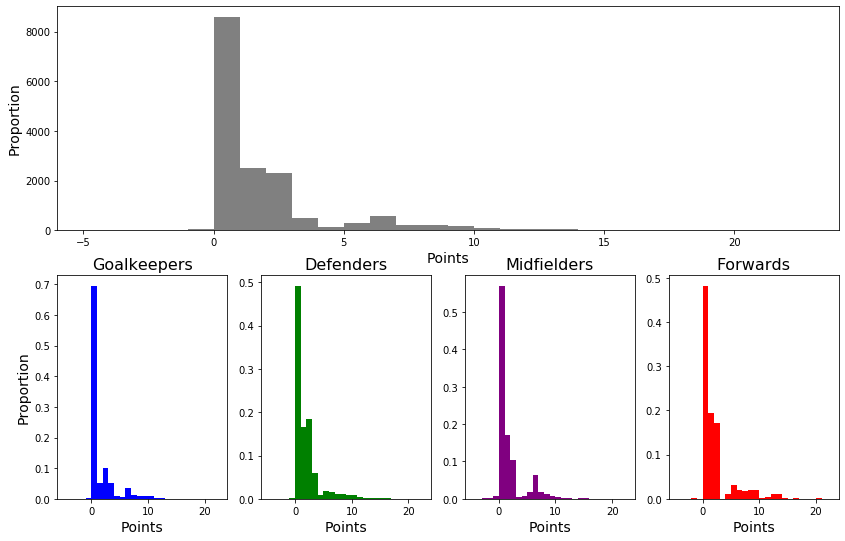

In [9]:
fig = plt.figure(figsize=(14,14))

# Get histogram bins from integers between the min and max points
#nbins = int(max_points-min_points + 1)
nbins = np.arange(min_pts, max_pts + 1)

# Subplots for all players, and then broken down by position
ax_all = plt.subplot2grid((3,4), (0,0), colspan=4)
ax_gkp = plt.subplot2grid((3,4), (1,0))
ax_def = plt.subplot2grid((3,4), (1,1))
ax_mid = plt.subplot2grid((3,4), (1,2))
ax_for = plt.subplot2grid((3,4), (1,3))

ax_all.hist(main_data['total_points'].dropna(), bins=nbins, color='grey')
ax_gkp.hist(main_data.loc[main_data['position_id']=='1',
                              'total_points'].dropna(), bins=nbins, color='blue', density=True)
ax_mid.hist(main_data.loc[main_data['position_id']=='2',
                              'total_points'].dropna(), bins=nbins, color='purple', density=True)
ax_def.hist(main_data.loc[main_data['position_id']=='3',
                              'total_points'].dropna(), bins=nbins, color='green', density=True)
ax_for.hist(main_data.loc[main_data['position_id']=='4',
                              'total_points'].dropna(), bins=nbins, color='red', density=True)

ax_gkp.set_title('Goalkeepers', fontsize=16)
ax_def.set_title('Defenders', fontsize=16)
ax_mid.set_title('Midfielders', fontsize=16)
ax_for.set_title('Forwards', fontsize=16)

for ax in [ax_all, ax_gkp, ax_def, ax_mid, ax_for]:
    ax.set_xlim(min_pts, max_pts)
    ax.set_xlabel('Points', fontsize=14)

ax_all.set_ylabel('Proportion', fontsize=14)
ax_gkp.set_ylabel('Proportion', fontsize=14)

plt.show()

We can see some bimodality in the target variable. Note, however, there are lots of players who do not play in each game.

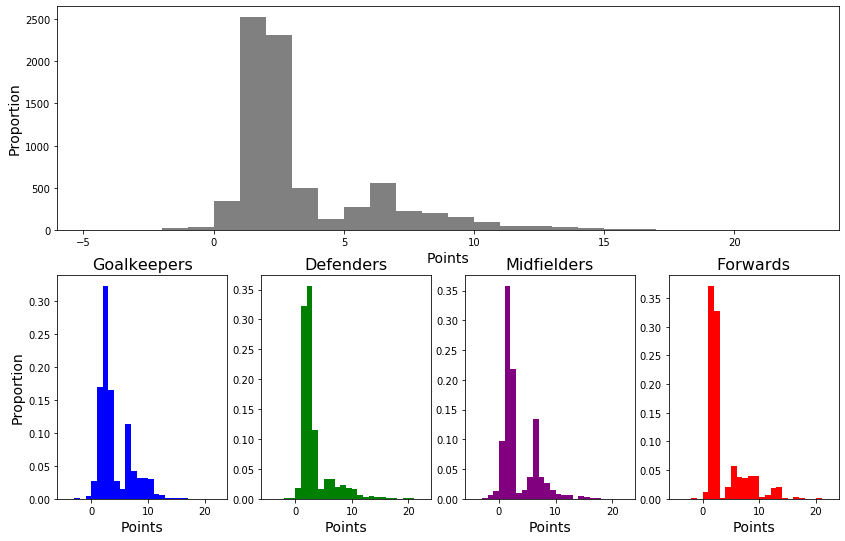

In [10]:
only_those_who_played = main_data.loc[main_data['minutes'] > 0]

fig = plt.figure(figsize=(14,14))

# Get histogram bins from integers between the min and max points
#nbins = int(max_points-min_points + 1)
nbins = np.arange(min_pts, max_pts + 1)

# Subplots for all players, and then broken down by position
ax_all = plt.subplot2grid((3,4), (0,0), colspan=4)
ax_gkp = plt.subplot2grid((3,4), (1,0))
ax_def = plt.subplot2grid((3,4), (1,1))
ax_mid = plt.subplot2grid((3,4), (1,2))
ax_for = plt.subplot2grid((3,4), (1,3))

ax_all.hist(only_those_who_played['total_points'].dropna(), bins=nbins, color='grey')
ax_gkp.hist(only_those_who_played.loc[only_those_who_played['position_id']=='1',
                              'total_points'].dropna(), bins=nbins, color='blue', density=True)
ax_mid.hist(only_those_who_played.loc[only_those_who_played['position_id']=='2',
                              'total_points'].dropna(), bins=nbins, color='purple', density=True)
ax_def.hist(only_those_who_played.loc[only_those_who_played['position_id']=='3',
                              'total_points'].dropna(), bins=nbins, color='green', density=True)
ax_for.hist(only_those_who_played.loc[only_those_who_played['position_id']=='4',
                              'total_points'].dropna(), bins=nbins, color='red', density=True)

ax_gkp.set_title('Goalkeepers', fontsize=16)
ax_def.set_title('Defenders', fontsize=16)
ax_mid.set_title('Midfielders', fontsize=16)
ax_for.set_title('Forwards', fontsize=16)

for ax in [ax_all, ax_gkp, ax_def, ax_mid, ax_for]:
    ax.set_xlim(min_pts, max_pts)
    ax.set_xlabel('Points', fontsize=14)

ax_all.set_ylabel('Proportion', fontsize=14)
ax_gkp.set_ylabel('Proportion', fontsize=14)

plt.show()

The bimodality is even clearer. Looking at this, it might be useful to perform binary classification on whether or not a player will get more than 4 points in a game. We do have the issue of unbalanced data, but this will be slightly less of an issue if we were to have a variable saying/predicting whether a player is to play.

One of the other options was to use Poisson regression to model the discrete number of points directly. However, we have several problems. From above, players can get negative points and there are many zeros. We also have clear bimodality. Finally, a key assumption of Poisson regression is that the mean and variance of the response are equal. This is not the case with our data:

In [11]:
ratio_mean_to_var = only_those_who_played['total_points'].mean()/only_those_who_played['total_points'].var()
print(f'Ratio of mean to variance of points: {ratio_mean_to_var}')

Ratio of mean to variance of points: 0.33710920828616164


We could look into negative binomial regression to address the problem of overdispersion. However, the multitude of violated assumptions will require lots of effort to overcome, so maybe this is something to focus on at a later date.

For now, I will focus on linear regression and classification approaches. For the latter, I will look to predict whether a player will score 5 or more points in a gameweek, as this seems to be a good split point and also what as a previous fantasy football player I would think is a useful score for a player to get.

# Deciding on approach
From the above analysis, it looks like it is worth, at least initially, performing binary classification to determine whether a player scores lots (5+) points. However, the above analysis has also shown a substantial amount of players do not play each game, meaning that there are a lot of zeros.
As a result, I am going to perform two separate classifications:
- Does a player play in the game?
- Assuming they play, will a player score 5 or more points?

I will train the second model only on players which do play, but predict for all future players. Alongside this, the inclusion of the separate playing a game prediction will allow filtering by players likely to play.

# Feature engineering
There are some features I expect to be able to derive from the data and which are likely to have some sort of impact on predictions.
For efficiency, I will be able to perform some on the data before splitting into training and testing sets. These might be combinations of column values for each individual row, or previous game data for players (remembering splitting will take players into account).

Other features to create may need to be aggregated from the whole data, so I will create classes and invoke those in the modelling pipelines.

### From other tables
There are several other tables in the database which contain information about the teams players play for and the games themselves.

#### Teams

In [12]:
team_data = pd.read_sql("""SELECT * FROM teams""", engine)
team_data.sort_values(['team_id'], inplace=True)
team_data

,team_id,team_id_long,team_name_long,team_name,team_strength,team_strength_overall_home,team_strength_overall_away,team_strength_attack_home,team_strength_attack_away,team_strength_defence_home,team_strength_defence_away
0,1,3,Arsenal,ARS,4,1230,1270,1150,1190,1280,1330
1,10,14,Liverpool,LIV,5,1340,1360,1300,1330,1340,1370
2,11,43,Man City,MCI,5,1320,1350,1270,1330,1350,1370
3,12,1,Man Utd,MUN,4,1250,1300,1270,1310,1280,1340
4,13,4,Newcastle,NEW,3,1080,1110,1040,1090,1020,1030
5,14,45,Norwich,NOR,2,990,1030,990,1000,1030,1100
6,15,49,Sheffield Utd,SHU,3,1140,1190,1150,1190,1060,1110
7,16,20,Southampton,SOU,2,1050,1040,1010,1010,1050,1040
8,17,6,Spurs,TOT,4,1240,1280,1210,1290,1280,1290
9,18,57,Watford,WAT,3,1070,1090,1080,1120,1040,1120


There are several columns of interest relating to team strength - an attacking player playing for a team with a great attack may tend to score more points per game. Subsetting the columns to keep for later merge:

In [13]:
team_cols = ['team_id'] + [col for col in team_data.columns if col.startswith('team_strength')]

#### Team results and fixtures
Similarly, by looking at previous results, we may be able to find teams which are in form, and likely for their players to continue scoring well.

In [14]:
results = pd.read_sql("""SELECT * FROM team_results""", engine)
results.head(10)

,team_id,fixture_id,fixture_id_long,gameweek_id,opponent_team_id,goals_conceded,goals_scored,fixture_kickoff_datetime,played,fixture_home,win,draw,loss,points,goal_difference
0,1,10,1059711,1,13,0.0,1.0,2019-08-11 14:00:00,True,False,1.0,0.0,0.0,3,1.0
1,1,11,1059712,2,5,1.0,2.0,2019-08-17 12:30:00,True,True,1.0,0.0,0.0,3,1.0
2,1,24,1059725,3,10,3.0,1.0,2019-08-24 17:30:00,True,False,0.0,0.0,1.0,0,-2.0
3,1,31,1059732,4,17,2.0,2.0,2019-09-01 16:30:00,True,True,0.0,1.0,0.0,1,0.0
4,1,49,1059750,5,18,2.0,2.0,2019-09-15 16:30:00,True,False,0.0,1.0,0.0,1,0.0
5,1,51,1059752,6,2,2.0,3.0,2019-09-22 16:30:00,True,True,1.0,0.0,0.0,3,1.0
6,1,67,1059768,7,12,1.0,1.0,2019-09-30 20:00:00,True,False,0.0,1.0,0.0,1,0.0
7,1,71,1059772,8,3,0.0,1.0,2019-10-06 14:00:00,True,True,1.0,0.0,0.0,3,1.0
8,1,88,1059789,9,15,1.0,0.0,2019-10-21 20:00:00,True,False,0.0,0.0,1.0,0,-1.0
9,1,91,1059792,10,7,2.0,2.0,2019-10-27 16:30:00,True,True,0.0,1.0,0.0,1,0.0


Things of interest here include the opponent team, goals each team has scored (plus the result), date/time of the match, and whether it was played home or away.

In [15]:
results_cols = ['fixture_id', 'team_id' ,'opponent_team_id', 'goals_scored',
               'goals_conceded', 'win', 'loss', 'draw']

The results table is just a version of the fixtures table, except being a bit more processed. Two additional useful columns in the fixtures table are home_team_fixture_difficulty and away_team_fixture_difficulty, which can be later merged on to the results data.

In [16]:
fixtures = pd.read_sql("""SELECT * FROM fixtures""", engine)
fixtures.head(10)

,fixture_id,fixture_id_long,gameweek_id,fixture_kickoff_datetime,fixture_started,fixture_finished,fixture_finished_provisional,fixture_minutes,home_team_id,away_team_id,home_team_score,away_team_score,home_team_fixture_difficulty,away_team_fixture_difficulty
0,1,1059702,1,2019-08-09 20:00:00,True,True,True,90,10,14,4.0,1.0,2,5
1,10,1059711,1,2019-08-11 14:00:00,True,True,True,90,13,1,0.0,1.0,4,3
2,100,1059801,10,2019-10-26 15:00:00,True,True,True,90,19,15,1.0,1.0,3,2
3,101,1059803,11,2019-11-02 15:00:00,True,True,True,90,1,20,1.0,1.0,3,4
4,102,1059804,11,2019-11-02 15:00:00,True,True,True,90,2,10,1.0,2.0,4,2
5,103,1059802,11,2019-11-02 12:30:00,True,True,True,90,3,12,1.0,0.0,4,3
6,104,1059805,11,2019-11-02 15:00:00,True,True,True,90,4,14,2.0,0.0,2,3
7,105,1059806,11,2019-11-03 14:00:00,True,True,True,90,7,9,0.0,2.0,4,2
8,106,1059807,11,2019-11-03 16:30:00,True,True,True,90,8,17,1.0,1.0,4,3
9,107,1059808,11,2019-11-02 15:00:00,True,True,True,90,11,16,2.0,1.0,2,5


In [17]:
fixtures_cols = ['fixture_id', 'home_team_id', 'away_team_id', 'home_team_fixture_difficulty', 'away_team_fixture_difficulty']

In [18]:
def show_table(table, eng, rows=10):
    print(pd.read_sql(f'SELECT * FROM {table}', eng).head(rows))

# ==> Make function to preprocess data

In [19]:
fixtures_home = fixtures[fixtures_cols].drop(columns=['away_team_id'])
fixtures_home.rename(columns={'home_team_id': 'team_id',
                             'home_team_fixture_difficulty': 'team_fixture_difficulty',
                             'away_team_fixture_difficulty': 'opponent_team_fixture_difficulty'}, inplace=True)

fixtures_away = fixtures[fixtures_cols].drop(columns=['home_team_id'])
fixtures_away.rename(columns={'away_team_id': 'team_id',
                             'away_team_fixture_difficulty': 'team_fixture_difficulty',
                             'home_team_fixture_difficulty': 'opponent_team_fixture_difficulty'}, inplace=True)

In [20]:
combined_data = main_data.copy(deep=True)
print(f'Shape pre-merge: {combined_data.shape}')
combined_data = combined_data.merge(team_data[team_cols], how='left', on='team_id')

rename_cols = {'goals_scored': 'team_goals_scored',
               'goals_conceded': 'team_goals_conceded'}
combined_data = combined_data.merge(results[results_cols].rename(columns=rename_cols), how='left', on=['fixture_id', 'team_id'])

rename_cols = {k: f'opponent_{k}' for k in team_cols}
combined_data = combined_data.merge(team_data[team_cols].rename(columns=rename_cols), how='left', on='opponent_team_id')


combined_data = combined_data.merge(fixtures_home, how='left', on=['team_id', 'fixture_id'])
combined_data = combined_data.merge(fixtures_away, how='left', on=['team_id', 'fixture_id'])

combined_data['team_fixture_difficulty'] = combined_data['team_fixture_difficulty_x']\
                                                    .combine_first(combined_data['team_fixture_difficulty_y'])
combined_data['opponent_team_fixture_difficulty'] = combined_data['opponent_team_fixture_difficulty_x']\
                                                    .combine_first(combined_data['opponent_team_fixture_difficulty_y'])
combined_data.drop(columns=['team_fixture_difficulty_x',
                           'team_fixture_difficulty_y',
                           'opponent_team_fixture_difficulty_x',
                           'opponent_team_fixture_difficulty_y'], inplace=True)
print(f'Shape post-merge: {combined_data.shape}')

Shape pre-merge: (15870, 35)
Shape post-merge: (15870, 57)


In [21]:
combined_data.isna().sum().sort_values(ascending=False).head()

opponent_team_fixture_difficulty    0
threat                              0
influence                           0
bps                                 0
bonus                               0
dtype: int64

The merges worked successfully and no missing values have been introduced.

### Previous games
The dataframe has quite a few features already, but most of them refer to the game the number of points is for. Before a game we obviously won't know the values for these features!

A simple solution is to, for each player, look to past games rather than dropping the values.

In [22]:
combined_data.columns

Index(['player_id', 'fixture_id', 'fixture_id_long', 'gameweek_id', 'team_id',
       'position_id', 'total_points', 'fixture_home', 'home_team_id',
       'away_team_id', 'home_team_score', 'away_team_score', 'minutes',
       'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
       'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'ict_index', 'value', 'transfers_balance', 'selected',
       'transfers_in', 'transfers_out', 'kickoff_datetime', 'team_strength',
       'team_strength_overall_home', 'team_strength_overall_away',
       'team_strength_attack_home', 'team_strength_attack_away',
       'team_strength_defence_home', 'team_strength_defence_away',
       'opponent_team_id', 'team_goals_scored', 'team_goals_conceded', 'win',
       'loss', 'draw', 'opponent_team_strength',
       'opponent_team_strength_overall_home',
       'opponent_team_strength_overall_away

In [23]:
combined_data.head()

,player_id,fixture_id,fixture_id_long,gameweek_id,team_id,position_id,total_points,fixture_home,home_team_id,away_team_id,home_team_score,away_team_score,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,value,transfers_balance,selected,transfers_in,transfers_out,kickoff_datetime,team_strength,team_strength_overall_home,team_strength_overall_away,team_strength_attack_home,team_strength_attack_away,team_strength_defence_home,team_strength_defence_away,opponent_team_id,team_goals_scored,team_goals_conceded,win,loss,draw,opponent_team_strength,opponent_team_strength_overall_home,opponent_team_strength_overall_away,opponent_team_strength_attack_home,opponent_team_strength_attack_away,opponent_team_strength_defence_home,opponent_team_strength_defence_away,team_fixture_difficulty,opponent_team_fixture_difficulty
0,1,10,1059711,1,1,2,0.0,False,13,1,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,33117.0,0.0,0.0,2019-08-11 14:00:00,4,1230,1270,1150,1190,1280,1330,13,1.0,0.0,1.0,0.0,0.0,3,1080,1110,1040,1090,1020,1030,3.0,4.0
1,1,11,1059712,2,1,2,0.0,True,1,5,2.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,-5280.0,36709.0,2868.0,8148.0,2019-08-17 12:30:00,4,1230,1270,1150,1190,1280,1330,5,2.0,1.0,1.0,0.0,0.0,3,1050,1110,1060,1130,1050,1050,2.0,4.0
2,1,24,1059725,3,1,2,0.0,False,10,1,3.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,-6882.0,30975.0,534.0,7416.0,2019-08-24 17:30:00,4,1230,1270,1150,1190,1280,1330,10,1.0,3.0,0.0,1.0,0.0,5,1340,1360,1300,1330,1340,1370,5.0,4.0
3,1,31,1059732,4,1,2,0.0,True,1,17,2.0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,-3872.0,28096.0,346.0,4218.0,2019-09-01 16:30:00,4,1230,1270,1150,1190,1280,1330,17,2.0,2.0,0.0,0.0,1.0,4,1240,1280,1210,1290,1280,1290,4.0,4.0
4,1,49,1059750,5,1,2,0.0,False,18,1,2.0,2.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0,-2073.0,26902.0,581.0,2654.0,2019-09-15 16:30:00,4,1230,1270,1150,1190,1280,1330,18,2.0,2.0,0.0,0.0,1.0,3,1070,1090,1080,1120,1040,1120,2.0,4.0


In [24]:
# Need to use minutes in both lagged variables and as a later response variable
combined_data['total_minutes'] = combined_data['minutes']
# Need to also keep second copy of total_points to use as lagged variable
combined_data['points'] = combined_data['total_points']

cols_not_known_in_advance = ['points',
                            'home_team_score',
                            'away_team_score',
                            'minutes',
                            'goals_scored',
                            'assists',
                            'clean_sheets',
                            'goals_conceded',
                            'own_goals',
                            'penalties_saved',
                            'penalties_missed',
                            'yellow_cards',
                            'red_cards',
                            'saves',
                            'bonus',
                            'bps',
                            'influence',
                            'creativity',
                            'threat',
                            'ict_index',
                            'team_goals_scored',
                            'win',
                            'loss',
                            'draw']

The above columns are not known until the total_points is known, so I will 'lag' them in the data - for each player there'll be additional features in place of these, corresponding to the values in the previous game.
It would be good to have multiple games' data for each player, but this'll mean reducing the number of rows in the data (as the first few games obviously do not have much previous game data).

In [25]:
combined_data.sort_values(['player_id', 'kickoff_datetime'], inplace=True)
gb_obj = combined_data.groupby('player_id')
combined_data[[f'previous_{col}' for col in cols_not_known_in_advance]] = gb_obj[cols_not_known_in_advance].shift(1)
combined_data.drop(columns=cols_not_known_in_advance, inplace=True)

In [26]:
combined_data.head()

,player_id,fixture_id,fixture_id_long,gameweek_id,team_id,position_id,total_points,fixture_home,home_team_id,away_team_id,value,transfers_balance,selected,transfers_in,transfers_out,kickoff_datetime,team_strength,team_strength_overall_home,team_strength_overall_away,team_strength_attack_home,team_strength_attack_away,team_strength_defence_home,team_strength_defence_away,opponent_team_id,team_goals_conceded,opponent_team_strength,opponent_team_strength_overall_home,opponent_team_strength_overall_away,opponent_team_strength_attack_home,opponent_team_strength_attack_away,opponent_team_strength_defence_home,opponent_team_strength_defence_away,team_fixture_difficulty,opponent_team_fixture_difficulty,total_minutes,previous_points,previous_home_team_score,previous_away_team_score,previous_minutes,previous_goals_scored,previous_assists,previous_clean_sheets,previous_goals_conceded,previous_own_goals,previous_penalties_saved,previous_penalties_missed,previous_yellow_cards,previous_red_cards,previous_saves,previous_bonus,previous_bps,previous_influence,previous_creativity,previous_threat,previous_ict_index,previous_team_goals_scored,previous_win,previous_loss,previous_draw
0,1,10,1059711,1,1,2,0.0,False,13,1,55.0,0.0,33117.0,0.0,0.0,2019-08-11 14:00:00,4,1230,1270,1150,1190,1280,1330,13,0.0,3,1080,1110,1040,1090,1020,1030,3.0,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,11,1059712,2,1,2,0.0,True,1,5,55.0,-5280.0,36709.0,2868.0,8148.0,2019-08-17 12:30:00,4,1230,1270,1150,1190,1280,1330,5,1.0,3,1050,1110,1060,1130,1050,1050,2.0,4.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1,24,1059725,3,1,2,0.0,False,10,1,54.0,-6882.0,30975.0,534.0,7416.0,2019-08-24 17:30:00,4,1230,1270,1150,1190,1280,1330,10,3.0,5,1340,1360,1300,1330,1340,1370,5.0,4.0,0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0
3,1,31,1059732,4,1,2,0.0,True,1,17,54.0,-3872.0,28096.0,346.0,4218.0,2019-09-01 16:30:00,4,1230,1270,1150,1190,1280,1330,17,2.0,4,1240,1280,1210,1290,1280,1290,4.0,4.0,0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,1,49,1059750,5,1,2,0.0,False,18,1,53.0,-2073.0,26902.0,581.0,2654.0,2019-09-15 16:30:00,4,1230,1270,1150,1190,1280,1330,18,2.0,3,1070,1090,1080,1120,1040,1120,2.0,4.0,0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0


### Derived features
There are several more features we can derive from the data.
- **Form:** A measure of a player's form is difficult to construct as it would require several gameweeks worth of data. As mentioned above, this would cut down the data size too much for my current liking. It should, however, be the case that previous gameweek features should act as a proxy for this, albeit only base on a single game.
- **Popularity:** During the data preparation there was one additional feature which came to mind which I have not yet added: a more appropriate measure of the number of FPL player teams containing each player. This exists as the variable 'selected', however each gameweek there are different numbers of teams entered into the competition which means that our assumption that each gameweek is considered 'equal' breaks down. While this assumption is imperfect anyway (double gameweeks, player transfers, teams playing in other competitions etc.), over the course of the season the player base increases dramatically.
- **Further team-level statistics:** Along with things like goals previously scored, conceded by a team, there are other features I could derive per team such as numbers of unique scorers etc. However, I will leave this to a later date.

For now I will just focus on the popularity variable. However, as this is based across all players per gameweek, it would be wrong (with the planned cross validation where I will allow each player to only have rows in either the train or validation data) to calculate this in advance. It will need to be calculated in the cross validation loop. With Scikit-learn pipelines, this is simple to do by creating a custom-transformer subclassing BaseEstimator and TransformerMixin.

This will be useful for other variables such as transfers which also depend on the playerbase size.

In [27]:
full_data = combined_data.copy(deep=True)

by_group = 'gameweek_id'
variables = ['selected', 'transfers_in', 'transfers_out']
quantiles = [round(i/10, 2) for i in range(10)]

quantile_data = full_data.groupby(by_group)[variables].quantile(quantiles)
quantile_data = quantile_data.reset_index().rename(columns={'level_1': 'quantile'})
low_cols = [f'{b}_lower' for b in variables]
quantile_data.rename(columns=dict(zip(variables, low_cols)), inplace=True)

quantile_data[[f'{b}_upper' for b in variables]] = quantile_data.groupby(by_group)[low_cols].shift(-1).fillna(9999)

full_data2 = full_data.merge(quantile_data, how='left', on=by_group)
for var in variables:
    full_data2[f'quantile_{var}'] = np.nan
    mask = (full_data2[var] >= full_data2[f'{var}_lower']) & (full_data2[var] < full_data2[f'{var}_upper'])
    full_data2.loc[mask, f'quantile_{var}'] = full_data2.loc[mask, f'quantile']
    
full_cols = [col for col in full_data2.columns if not col.startswith('quantile_') and not col.endswith(('_upper', '_lower'))]
quantile_cols = [col for col in full_data2.columns if col.startswith('quantile_')]
full_data2 = full_data2.groupby(['player_id', 'gameweek_id', 'fixture_id'])[quantile_cols].max().reset_index()
full_data2.head(10)

,player_id,gameweek_id,fixture_id,quantile_selected,quantile_transfers_in,quantile_transfers_out
0,1,1,10,0.5,0.9,0.9
1,1,2,11,0.5,0.5,0.6
2,1,3,24,0.4,0.3,0.5
3,1,4,31,0.4,0.2,0.4
4,1,5,49,0.4,0.3,0.4
5,1,6,51,0.4,0.3,0.4
6,1,7,67,0.4,0.3,0.3
7,1,8,71,0.4,0.4,0.3
8,1,9,88,0.4,0.4,0.3
9,1,10,91,0.4,0.3,0.3


This is far too slow and will make cross validation too frustrating to run, so for now I will simply calculate the percentage selected. A simpler way which doesn't require calculating expensive cross joins (or an expensive merge) is to divide the numbers selected by the total player base.

Note that if it is a new gameweek (as will be the case for new predictions, we will need to calculate percentages from only that current gameweeks data for the new gameweeks, so the transform step in the pipeline step will need to reuse the percentage calculation.

The constant, 15, is used as this is the size of a user's squad (i.e. they select 15 players per gameweek so we need to divide the total number of selected players by 15 in the calculation).

In [28]:
class PercentageCalc(BaseEstimator, TransformerMixin):
    """For one or more variables, perform a sort of normalisation by dividing by the total
    for that column (across a particular by group), multipled by a constant (to reflect player base)"""
    
    def __init__(self,
                 by_group='gameweek_id',
                 variables=['selected', 'transfers_in', 'transfers_out'],
                 final_suffix='_perc',
                 constant=15):
        self._by_group = by_group
        self._variables = variables
        self._constant = constant
        self._final_suffix = final_suffix
        self._temp_columns = [f'{k}{"_tmp"}' for k in self._variables]
        self.totals = None
        
    def _needed_new_bygroup(self, X):
        """Check to see whether any new by-groups not in training data - return them if so as set"""
        all_groups = X[self._by_group]
        return set(all_groups) - set(self.totals.index)
    
    def _calc_totals(self, X):
        """Estimate the total of each variable (i.e. total number of users variable corresponds to)"""
        percs = X.groupby(self._by_group)[self._variables].sum()/self._constant
        if isinstance(percs, pd.DataFrame):
            percs.columns = self._temp_columns
            return percs
        else:
            return percs.to_frame(name=f'{variables[0]}')
    
    def _apply_totals(self, X, totals):
        """Add on totals to data"""
        return X.merge(totals, how='left', left_on=self._by_group, right_index=True)
    
    def _calc_final(self, X):
        """Calculate proportion"""
        for c in self._variables:
            X[f'{c}{self._final_suffix}'] = X[c] / X[f'{c}{"_tmp"}']
            X[f'{c}{self._final_suffix}'].fillna(0, inplace=True)
        return X
    
    def _drop_original_cols(self, X):
        return X.drop(columns=self._variables + self._temp_columns)        
        
    def fit(self, X, y=None):
        self.totals = self._calc_totals(X)
        return self
        
    def transform(self, X, y=None):
        new_calcs = self._needed_new_bygroup(X)
        if new_calcs is None:
            # All by groups in transform data in train data so can just apply existing numbers
            X = self._apply_totals(X, self.totals)
        else:
            new_totals = self._calc_totals(X.loc[X[self._by_group].isin(new_calcs)])
            final_totals = pd.concat((self.totals, new_totals))
            X = self._apply_totals(X, final_totals)
        X = self._calc_final(X)
        return self._drop_original_cols(X)

Testing this class works:

In [29]:
testdata = combined_data.loc[:,
                         ['player_id', 'gameweek_id'] +
                         ['selected', 'transfers_in', 'transfers_out', 'fixture_id']].copy(deep=True)

cfv = PercentageCalc(by_group='gameweek_id',
                     variables=['selected', 'transfers_in', 'transfers_out'],
                     constant=15)
cfv.fit(testdata.loc[testdata.gameweek_id <= 28])
output = cfv.transform(testdata)
output.head(10)

,player_id,gameweek_id,fixture_id,selected_perc,transfers_in_perc,transfers_out_perc
0,1,1,10,0.006084,0.000000,0.000000
1,1,2,11,0.005992,0.004581,0.013014
2,1,3,24,0.004879,0.000637,0.008849
3,1,4,31,0.004303,0.000420,0.005122
4,1,5,49,0.004030,0.000754,0.003444
5,1,6,51,0.003902,0.000751,0.002847
6,1,7,67,0.003761,0.000614,0.002609
7,1,8,71,0.003681,0.000863,0.002380
8,1,9,88,0.003637,0.000846,0.001761
9,1,10,91,0.003602,0.000612,0.001610


### Other transformations
There are some final transformations that can be made on the data which can be calculated pre-prediction. These mostly relate to the times of each game:
- Conversion of datetimes to numeric including days of week, hour of day, etc.
- Days since last game, as players tired from recent exertions may not score highly 
- Event day, as players playing on the final day in a gameweek may be under more presssure

#### Time of the game
A simple way to extract the game time from the datetime in a way which ML methods can use it to derive cyclic features - e.g. two new features which are the sine and cosine transforms of the seconds in a day to take the cyclic nature of the day into consideration. An alternative would be to bin the times, which while perhaps not too bad an approach for this, would lose a small amount of information.

In [30]:
combined_data['kickoff_datetime_seconds'] = combined_data['kickoff_datetime'].dt.hour*3600 + combined_data['kickoff_datetime'].dt.minute*60 + combined_data['kickoff_datetime'].dt.second
combined_data['kickoff_feature_sin'] = np.sin(2*np.pi*combined_data['kickoff_datetime_seconds']/86400)
combined_data['kickoff_feature_cos'] = np.cos(2*np.pi*combined_data['kickoff_datetime_seconds']/86400)

#### Day of the game
Is the game taking place on a Saturday or a Wednesday (etc.)?

In [31]:
combined_data['kickoff_feature_game_day_of_week'] = combined_data['kickoff_datetime'].dt.dayofweek

#### Days since last game
Note that this obviously won't include games in other competitions (at least for now).

In [32]:
combined_data.sort_values(by=['player_id', 'kickoff_datetime'], inplace=True)
combined_data['kickoff_feature_time_diff'] = combined_data.groupby(['player_id'])['kickoff_datetime'].diff().dt.days

#### Day of gameweek
The number of days (rounded down) after first game in gameweek kicks off.

In [33]:
gameweek_min_dates = combined_data.groupby(['gameweek_id'])['kickoff_datetime'].min().to_frame(name='gw_min')
combined_data = combined_data.merge(gameweek_min_dates, how='left', left_on='gameweek_id', right_index=True, validate='many_to_one')
combined_data['kickoff_feature_gameday'] = combined_data['kickoff_datetime'] - combined_data['gw_min']
combined_data['kickoff_feature_gameday'] = np.floor(combined_data['kickoff_feature_gameday'] / np.timedelta64(1, 'D'))

In [34]:
combined_data.sort_values(by=['player_id', 'gameweek_id', 'kickoff_datetime'], inplace=True)
combined_data.drop(columns=['kickoff_datetime', 'kickoff_datetime_seconds', 'gw_min'], inplace=True)
combined_data.head()

,player_id,fixture_id,fixture_id_long,gameweek_id,team_id,position_id,total_points,fixture_home,home_team_id,away_team_id,value,transfers_balance,selected,transfers_in,transfers_out,team_strength,team_strength_overall_home,team_strength_overall_away,team_strength_attack_home,team_strength_attack_away,team_strength_defence_home,team_strength_defence_away,opponent_team_id,team_goals_conceded,opponent_team_strength,opponent_team_strength_overall_home,opponent_team_strength_overall_away,opponent_team_strength_attack_home,opponent_team_strength_attack_away,opponent_team_strength_defence_home,opponent_team_strength_defence_away,team_fixture_difficulty,opponent_team_fixture_difficulty,total_minutes,previous_points,previous_home_team_score,previous_away_team_score,previous_minutes,previous_goals_scored,previous_assists,previous_clean_sheets,previous_goals_conceded,previous_own_goals,previous_penalties_saved,previous_penalties_missed,previous_yellow_cards,previous_red_cards,previous_saves,previous_bonus,previous_bps,previous_influence,previous_creativity,previous_threat,previous_ict_index,previous_team_goals_scored,previous_win,previous_loss,previous_draw,kickoff_feature_sin,kickoff_feature_cos,kickoff_feature_game_day_of_week,kickoff_feature_time_diff,kickoff_feature_gameday
0,1,10,1059711,1,1,2,0.0,False,13,1,55.0,0.0,33117.0,0.0,0.0,4,1230,1270,1150,1190,1280,1330,13,0.0,3,1080,1110,1040,1090,1020,1030,3.0,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.500000,-0.866025,6,NaN,1.0
1,1,11,1059712,2,1,2,0.0,True,1,5,55.0,-5280.0,36709.0,2868.0,8148.0,4,1230,1270,1150,1190,1280,1330,5,1.0,3,1050,1110,1060,1130,1050,1050,2.0,4.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,-0.130526,-0.991445,5,5.0,0.0
2,1,24,1059725,3,1,2,0.0,False,10,1,54.0,-6882.0,30975.0,534.0,7416.0,4,1230,1270,1150,1190,1280,1330,10,3.0,5,1340,1360,1300,1330,1340,1370,5.0,4.0,0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,-0.991445,-0.130526,5,7.0,0.0
3,1,31,1059732,4,1,2,0.0,True,1,17,54.0,-3872.0,28096.0,346.0,4218.0,4,1230,1270,1150,1190,1280,1330,17,2.0,4,1240,1280,1210,1290,1280,1290,4.0,4.0,0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,-0.923880,-0.382683,6,7.0,1.0
4,1,49,1059750,5,1,2,0.0,False,18,1,53.0,-2073.0,26902.0,581.0,2654.0,4,1230,1270,1150,1190,1280,1330,18,2.0,3,1070,1090,1080,1120,1040,1120,2.0,4.0,0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,-0.923880,-0.382683,6,14.0,1.0


There are other features which could be derived which rely on other rows in the data (like done earlier with the selected column). However, due to the dataset not being particularly massive (half a season's worth of data), and these transforms tending to rely heavily on past data, which most rows won't have, I will forgo these for now.
- Number of players (with different characteristics) within team. Is the player well positioned within the team? Are they the main man or likely to be benched?
- Quantity of games e.g. in the last month
- Types of games (this week, the previous week, or upcoming) - if there's a relegation six-pointer coming up next week key players are more likely to be rested.

### External data
In the future, it would be worth augmenting the data with other sources such as:
- Other competition data - i.e. the fixtures and results of other competitions to gauge player morale and fatigue
- Sentiment data - player form may be shown through things such as Twitter messages
- Player attributes - player-level data such as how good a player is at different things. This could be got through FIFA data dumps for example.
- Another table in the data in this project does include things such as player injury data would would be really useful. Unfortunately, it is overwritten each update with new information (so not useful for previous gameweeks). I'm looking into adding this in.

# Feature exploration

In [32]:
data_example = combined_data.copy(deep=True)
cfv = PercentageCalc(by_group='gameweek_id',
                     variables=['selected', 'transfers_in', 'transfers_out'],
                     constant=15)
data_example = cfv.fit_transform(data_example)
data_example.head()

,player_id,fixture_id,fixture_id_long,gameweek_id,team_id,position_id,total_points,fixture_home,home_team_id,away_team_id,value,transfers_balance,kickoff_datetime,team_strength,team_strength_overall_home,team_strength_overall_away,team_strength_attack_home,team_strength_attack_away,team_strength_defence_home,team_strength_defence_away,opponent_team_id,team_goals_conceded,opponent_team_strength,opponent_team_strength_overall_home,opponent_team_strength_overall_away,opponent_team_strength_attack_home,opponent_team_strength_attack_away,opponent_team_strength_defence_home,opponent_team_strength_defence_away,team_fixture_difficulty,opponent_team_fixture_difficulty,total_minutes,previous_points,previous_home_team_score,previous_away_team_score,previous_minutes,previous_goals_scored,previous_assists,previous_clean_sheets,previous_goals_conceded,previous_own_goals,previous_penalties_saved,previous_penalties_missed,previous_yellow_cards,previous_red_cards,previous_saves,previous_bonus,previous_bps,previous_influence,previous_creativity,previous_threat,previous_ict_index,previous_team_goals_scored,previous_win,previous_loss,previous_draw,selected_perc,transfers_in_perc,transfers_out_perc
0,1,10,1059711,1,1,2,0.0,False,13,1,55.0,0.0,2019-08-11 14:00:00,4,1180,1240,1170,1170,1150,1200,13,0.0,3,1090,1100,1030,1040,980,990,2.0,3.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006084,0.000000,0.000000
1,1,11,1059712,2,1,2,0.0,True,1,5,55.0,-5280.0,2019-08-17 12:30:00,4,1180,1240,1170,1170,1150,1200,5,1.0,3,1110,1180,1130,1070,970,1110,3.0,4.0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.005992,0.004581,0.013014
2,1,24,1059725,3,1,2,0.0,False,10,1,54.0,-6882.0,2019-08-24 17:30:00,4,1180,1240,1170,1170,1150,1200,10,3.0,5,1340,1350,1310,1320,1310,1330,5.0,3.0,0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.004879,0.000637,0.008849
3,1,31,1059732,4,1,2,0.0,True,1,17,54.0,-3872.0,2019-09-01 16:30:00,4,1180,1240,1170,1170,1150,1200,17,2.0,4,1180,1240,1100,1130,1200,1140,3.0,4.0,0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.004303,0.000420,0.005122
4,1,49,1059750,5,1,2,0.0,False,18,1,53.0,-2073.0,2019-09-15 16:30:00,4,1180,1240,1170,1170,1150,1200,18,2.0,3,1030,1140,1120,1120,1020,1150,3.0,3.0,0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.004030,0.000754,0.003444


In [33]:
data_types = data_example.dtypes
data_types.sort_values(inplace=True)

no_use_cols = ['player_id', 'fixture_id', 'fixture_id_long', 'gameweek_id', 'total_minutes', 'total_points']
columns_categorical = [c for c in data_types[data_types == object].index if c not in no_use_cols]
numeric_cols = [c for c in data_example if c not in no_use_cols + columns_categorical]

In [35]:
no_use_cols

['player_id',
 'fixture_id',
 'fixture_id_long',
 'gameweek_id',
 'total_minutes',
 'total_points']

## Categoricals

In [34]:
columns_categorical

['opponent_team_id', 'away_team_id', 'home_team_id', 'position_id', 'team_id']

## Numerics

In [36]:
numeric_cols

['fixture_home',
 'value',
 'transfers_balance',
 'kickoff_datetime',
 'team_strength',
 'team_strength_overall_home',
 'team_strength_overall_away',
 'team_strength_attack_home',
 'team_strength_attack_away',
 'team_strength_defence_home',
 'team_strength_defence_away',
 'team_goals_conceded',
 'opponent_team_strength',
 'opponent_team_strength_overall_home',
 'opponent_team_strength_overall_away',
 'opponent_team_strength_attack_home',
 'opponent_team_strength_attack_away',
 'opponent_team_strength_defence_home',
 'opponent_team_strength_defence_away',
 'team_fixture_difficulty',
 'opponent_team_fixture_difficulty',
 'previous_points',
 'previous_home_team_score',
 'previous_away_team_score',
 'previous_minutes',
 'previous_goals_scored',
 'previous_assists',
 'previous_clean_sheets',
 'previous_goals_conceded',
 'previous_own_goals',
 'previous_penalties_saved',
 'previous_penalties_missed',
 'previous_yellow_cards',
 'previous_red_cards',
 'previous_saves',
 'previous_bonus',
 'pre